### Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns
from joblib import dump, load

In [2]:
HOME_DIR = '/Users/datatranslators/Documents/GitHub/acidoCEST-ML/'
DESTINATION = 'outputs'

In [3]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [4]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [5]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 1_000)

In [6]:
acidoCEST_ML.shape

(20000, 88)

In [7]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report

def train_lasso(Xdata, pH_observed, create_fig = 1):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter = 5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = 0, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    

    if create_fig == 1:
        print('------------------ LASSO ------------------ ')
        print()
        #print(', '.join(Xdata.columns.to_list()))
        print()
        print(m)


        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Train LASSO')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Test LASSO')
    
    return estimator.best_estimator_, score_train, score_test


def save_and_print(RFO, name='foo'):
    print('-----')
    for k in RFO.get_params().keys():
        print(f'{k}: {RFO.get_params()[k]}')
    
    dump(RFO, HOME_DIR + DESTINATION + f'/{name}.joblib') 

## LASSO

### - 4.2 and 5.6 only

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 4.02 % 
 test  = 4.05 %
-----
memory: None
steps: [('Scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))]
verbose: False
Scaler: StandardScaler()
lasso: Lasso(alpha=0.01, max_iter=5000, random_state=42)
Scaler__copy: True
Scaler__with_mean: True
Scaler__with_std: True
lasso__alpha: 0.01
lasso__copy_X: True
lasso__fit_intercept: True
lasso__max_iter: 5000
lasso__normalize: False
lasso__positive: False
lasso__precompute: False
lasso__random_state: 42
lasso__selection: cyclic
lasso__tol: 0.0001
lasso__warm_start: False


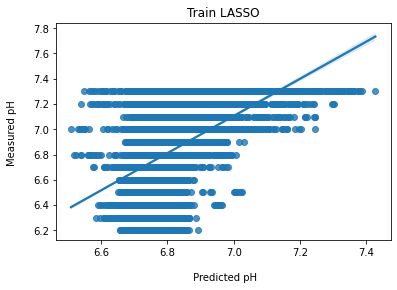

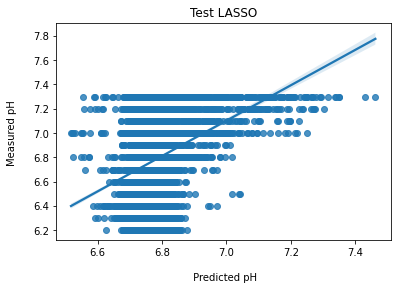

In [8]:
X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_lr, _, _ = train_lasso(X,Y)
save_and_print(reg_lr, name='LASSO_regressor_4256')

### - All spectra

(20000, 81)
------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.58 % 
 test  = 3.62 %
-----
memory: None
steps: [('Scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))]
verbose: False
Scaler: StandardScaler()
lasso: Lasso(alpha=0.01, max_iter=5000, random_state=42)
Scaler__copy: True
Scaler__with_mean: True
Scaler__with_std: True
lasso__alpha: 0.01
lasso__copy_X: True
lasso__fit_intercept: True
lasso__max_iter: 5000
lasso__normalize: False
lasso__positive: False
lasso__precompute: False
lasso__random_state: 42
lasso__selection: cyclic
lasso__tol: 0.0001
lasso__warm_start: False


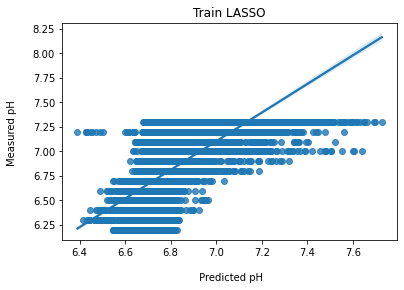

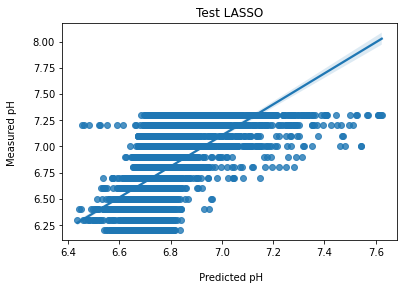

In [9]:
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 
print(Xdata.shape)
reg_lr, _, _ = train_lasso(Xdata,Ydata)
save_and_print(reg_lr, name='LASSO_regressor_allspectra')

### - All data

(20000, 87)
------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.61 %
-----
memory: None
steps: [('Scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))]
verbose: False
Scaler: StandardScaler()
lasso: Lasso(alpha=0.01, max_iter=5000, random_state=42)
Scaler__copy: True
Scaler__with_mean: True
Scaler__with_std: True
lasso__alpha: 0.01
lasso__copy_X: True
lasso__fit_intercept: True
lasso__max_iter: 5000
lasso__normalize: False
lasso__positive: False
lasso__precompute: False
lasso__random_state: 42
lasso__selection: cyclic
lasso__tol: 0.0001
lasso__warm_start: False


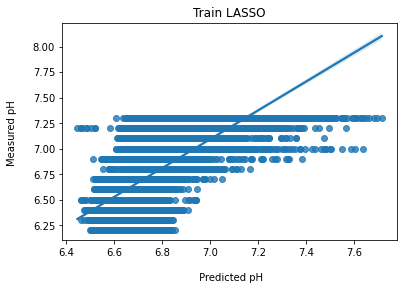

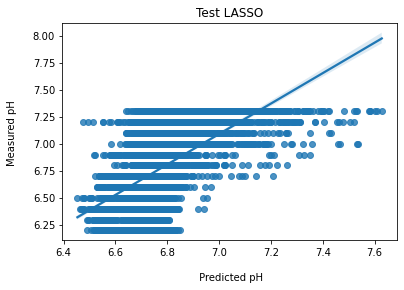

In [10]:
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH
print(Xdata.shape)
lasso_all_data, _, _  = train_lasso(Xdata,Ydata)
save_and_print(lasso_all_data, name='LASSO_regressor_alldata')

### - select features

Text(0, 0.5, 'Value \n')

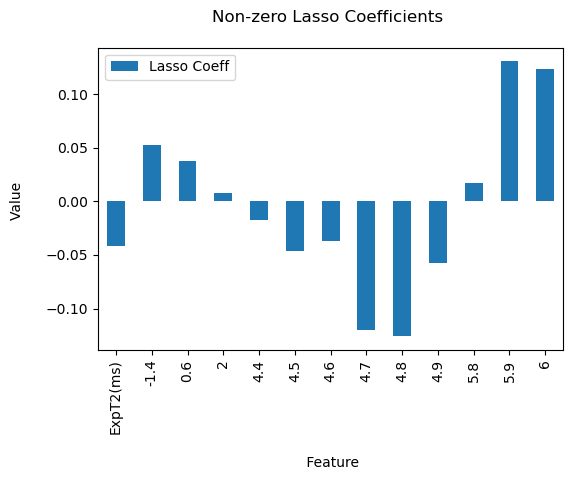

In [11]:
reg_lasso = lasso_all_data['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')

(20000, 13)
------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.61 %
-----
memory: None
steps: [('Scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))]
verbose: False
Scaler: StandardScaler()
lasso: Lasso(alpha=0.01, max_iter=5000, random_state=42)
Scaler__copy: True
Scaler__with_mean: True
Scaler__with_std: True
lasso__alpha: 0.01
lasso__copy_X: True
lasso__fit_intercept: True
lasso__max_iter: 5000
lasso__normalize: False
lasso__positive: False
lasso__precompute: False
lasso__random_state: 42
lasso__selection: cyclic
lasso__tol: 0.0001
lasso__warm_start: False


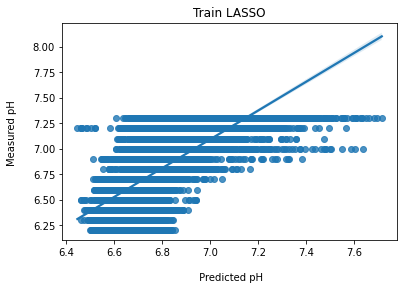

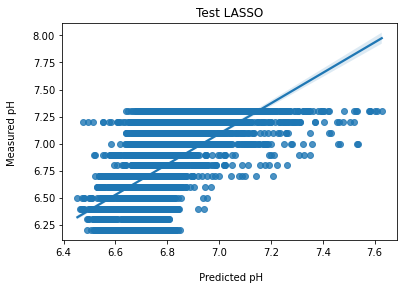

In [12]:
selected_cols_lasso = list(C[reg_lasso.coef_ != 0].index)

Xdata = acidoCEST_ML[selected_cols_lasso]
Ydata = acidoCEST_ML.pH
print(Xdata.shape)
lasso_selected, _, _ = train_lasso(Xdata[selected_cols_lasso],Ydata)

save_and_print(lasso_selected, name='LASSO_regressor_selected')

In [13]:
selected_cols_lasso

['ExpT2(ms)',
 '-1.4',
 '0.6',
 '2',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '5.8',
 '5.9',
 '6']

In [18]:
test

3.18

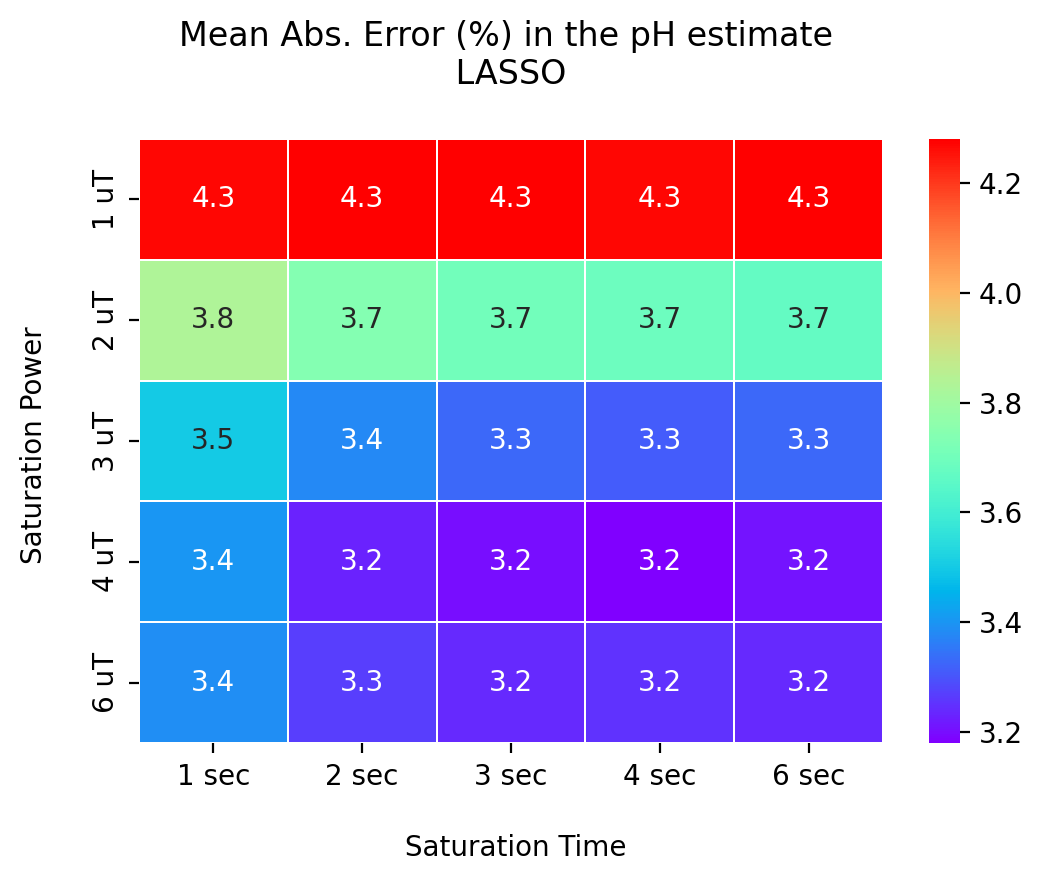

In [19]:
sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_lasso = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]
        D[selected_cols_lasso]
        
        Xdata = D[selected_cols_lasso]
        Ydata = D['pH']
        
        #_, train, test = train_lasso(Xdata,Ydata, create_fig=0)
        e = 100 * metrics.mean_absolute_percentage_error(Ydata, lasso_selected.predict(Xdata) )
        
        M_lasso.loc[p,:][t] = e.round(2)

M_lasso.columns = [str(int(x/1000)) + ' sec'  for x in M_lasso.columns]
M_lasso.index   = [f'{int(x)} uT' for  x in M_lasso.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_lasso.columns)
cols_.sort()

idx = list(M_lasso.index)
idx.sort()


sns.heatmap(M_lasso.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n LASSO \n')

plt.savefig(f'../figs/MATRIX_regression_LASSO.png',bbox_inches='tight')